<a href="https://colab.research.google.com/github/A-Wadhwani/ME597-Project/blob/main/Purdue_Power_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Models on Purdue Buildings

In [ ]:
# import the libraries
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import tensorflow as tf
import pandas as pd
from datetime import datetime
from sklearn.metrics import r2_score
print("TensorFlow version: ",tf.__version__)  #print the version of tensorflow

TensorFlow version:  2.3.0


In [ ]:
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

In [ ]:
#Helper Functions
def get_weekday2(year, month, day):
    dates = pd.DataFrame()
    dates['y'] = year
    dates['m'] = month
    dates['d'] = day
    dates['dates'] = dates['y'].astype('str') + '-' + dates['m'].astype('str') + '-' + dates['d'].astype('str')
    return get_weekday(dates['dates'])

#Get day of week based on date
def get_weekday(dates):
    return [1 if (datetime.strptime(d,"%Y-%m-%d").weekday() >= 5) else 0 for d in dates]

In [ ]:
from joblib import dump, load

#Load university model scalers
uni_x_scaler = load('uni_x_scaler.bin')
uni_y_scaler = load('uni_y_scaler.bin')

#Load solar model scalers
sol_x_scaler = load('sol_x_scaler.bin')
sol_y_scaler = load('sol_y_scaler.bin')

In [ ]:
#Load university model
uni_model= tf.keras.models.load_model('uni_model.h5')

#Load solar model
sol_model= tf.keras.models.load_model('sol_model.h5')

In [ ]:
#Load Purdue weather data
df_weather = pd.read_csv('https://raw.githubusercontent.com/A-Wadhwani/ME597-Project/main/Datasets/Purdue_Weather.csv')
df_weather.head()

,Year,Month,Day,Hour,Minute,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure
0,2019,1,1,0,30,0,0,0,0,0,0,8.7,1.5,245,100.00,7.2,981
1,2019,1,1,1,30,0,0,0,0,0,0,8.2,1.4,254,99.64,5.4,982
2,2019,1,1,2,30,0,0,0,0,0,0,7.3,1.3,265,99.24,3.8,984
3,2019,1,1,3,30,0,0,0,0,0,0,6.2,1.2,276,98.59,2.5,987
4,2019,1,1,4,30,0,0,0,0,0,0,5.2,1.2,280,97.39,1.6,989


## Power Consumption prediction

In [ ]:
def clean_data(df, skiprows = 0):
    df_weather = df
    df_weather = df_weather.drop(columns=['Hour', 'Minute'])
    df_weather = df_weather[df_weather.DNI != 0]

    #Take mean, max and min for each DNI in DataFrame and mean for everything else
    
    #Take mean, max and min for each DNI and Temperature in DataFrame and mean for everything else
    max_temp = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['Temperature']
    min_temp = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['Temperature']
    
    max_dni = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['DNI']
    min_dni = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['DNI']
    
    df_weather = pd.DataFrame(df_weather.groupby(['Year', 'Month', 'Day']).mean().reset_index())
    
    df_weather.insert(4, 'DNI Max', max_dni)
    df_weather.insert(5, 'DNI Min', min_dni)
    df_weather.insert(11, 'Temp Max', max_temp)
    df_weather.insert(12, 'Temp Min', min_temp)

    return df_weather

In [ ]:
def training_prep(data, square_feet, building_type):
    data = data.loc[:, ['Year', 'Month', 'Day', 'DNI', 'DNI Max', 'DNI Min', 'Wind Speed', 'Precipitable Water', 'Wind Direction', 'Relative Humidity', 'Temperature', 'Temp Max', 'Temp Min', 'Pressure']]
    data.loc[:, 'Weekday'] = get_weekday2(data['Year'], data['Month'], data['Day'])
    data = data.drop(['Wind Direction'], axis=1)
    data.loc[:, 'Square Feet'] = square_feet
    data.loc[:, 'Type'] = building_type
    return data

In [ ]:
#Taking Lawson Building: 10700 square feet and classroom (0)
uni_df = training_prep(clean_data(df_weather), 10700, 0)
uni_df.head()

,Year,Month,Day,DNI,DNI Max,DNI Min,Wind Speed,Precipitable Water,Relative Humidity,Temperature,Temp Max,Temp Min,Pressure,Weekday,Square Feet,Type
0,2019,1,1,8.0,8,8,2.500,0.900,88.7200,-0.500,-0.5,-0.5,1001.00,0,10700,0
1,2019,1,2,9.5,20,4,3.775,0.975,78.8375,1.325,2.1,-0.1,999.25,0,10700,0
2,2019,1,3,702.1,934,83,3.760,0.600,68.0630,1.170,3.9,-3.0,995.40,0,10700,0
3,2019,1,4,423.4,823,106,1.000,0.860,70.5130,3.740,6.3,-0.4,986.20,0,10700,0
4,2019,1,5,632.7,902,101,3.320,1.100,82.5930,5.850,10.1,-0.3,990.50,1,10700,0


In [ ]:
#Running model on data
x_scaled = uni_x_scaler.transform(uni_df)
y_scaled = uni_model.predict(x_scaled)
y_result = uni_y_scaler.inverse_transform(y_scaled)
pd.DataFrame(y_result).describe()

,0
count,364.000000
mean,830.789246
std,107.085663
min,633.321167
25%,765.372864
50%,814.083862
75%,882.194519
max,1404.280884


In [ ]:
#Storing power production value in new variableb 
uni_power_lawson =  y_result

In [ ]:
def clean_data(df, skiprows = 0):
    df_weather = df
    df_weather = df_weather.drop(columns=['Hour', 'Minute'])
    df_weather = df_weather[df_weather.DNI != 0]

    #Take mean, max and min for each DNI in DataFrame and mean for everything else
    
    #Take mean, max and min for each DNI and Temperature in DataFrame and mean for everything else
    max_temp = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['Temperature']
    min_temp = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['Temperature']
    
    max_dni = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['DNI']
    min_dni = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['DNI']
    
    df_weather = pd.DataFrame(df_weather.groupby(['Year', 'Month', 'Day']).mean().reset_index())
    
    df_weather.insert(4, 'DNI Max', max_dni)
    df_weather.insert(5, 'DNI Min', min_dni)
    df_weather.insert(11, 'Temp Max', max_temp)
    df_weather.insert(12, 'Temp Min', min_temp)

    return df_weather

In [ ]:
def training_prep(data, square_feet, building_type):
    data = data.loc[:, ['Year', 'Month', 'Day', 'DNI', 'DNI Max', 'DNI Min', 'Wind Speed', 'Precipitable Water', 'Wind Direction', 'Relative Humidity', 'Temperature', 'Temp Max', 'Temp Min', 'Pressure']]
    data.loc[:, 'Weekday'] = get_weekday2(data['Year'], data['Month'], data['Day'])
    data = data.drop(['Wind Direction'], axis=1)
    data.loc[:, 'Square Feet'] = square_feet
    data.loc[:, 'Type'] = building_type
    return data

In [ ]:
#Taking Lawson Building: 10700 square feet and classroom (0)
uni_df = training_prep(clean_data(df_weather), 10700, 0)
uni_df.head()

,Year,Month,Day,DNI,DNI Max,DNI Min,Wind Speed,Precipitable Water,Relative Humidity,Temperature,Temp Max,Temp Min,Pressure,Weekday,Square Feet,Type
0,2019,1,1,8.0,8,8,2.500,0.900,88.7200,-0.500,-0.5,-0.5,1001.00,0,10700,0
1,2019,1,2,9.5,20,4,3.775,0.975,78.8375,1.325,2.1,-0.1,999.25,0,10700,0
2,2019,1,3,702.1,934,83,3.760,0.600,68.0630,1.170,3.9,-3.0,995.40,0,10700,0
3,2019,1,4,423.4,823,106,1.000,0.860,70.5130,3.740,6.3,-0.4,986.20,0,10700,0
4,2019,1,5,632.7,902,101,3.320,1.100,82.5930,5.850,10.1,-0.3,990.50,1,10700,0


In [ ]:
#Running model on data
x_scaled = uni_x_scaler.transform(uni_df)
y_scaled = uni_model.predict(x_scaled)
y_result = uni_y_scaler.inverse_transform(y_scaled)
pd.DataFrame(y_result).describe()

,0
count,364.000000
mean,830.789246
std,107.085663
min,633.321167
25%,765.372864
50%,814.083862
75%,882.194519
max,1404.280884


In [ ]:
#Storing power consumption for lawson value in new variable 
uni_power_lawson =  y_result

## Solar Power Prediction data

In [ ]:
def clean_data(df, skiprows = 0):
    df_weather = df
    df_weather = df_weather.drop(columns=['Hour', 'Minute'])
    df_weather = df_weather[df_weather.DNI != 0]

    #Take mean, max and min for each DNI in DataFrame and mean for everything else
    
    #Take mean, max and min for each DNI and Temperature in DataFrame and mean for everything else
    max_temp = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['Temperature']
    min_temp = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['Temperature']
    
    max_dni = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['DNI']
    min_dni = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['DNI']
    
    df_weather = pd.DataFrame(df_weather.groupby(['Year', 'Month', 'Day']).mean().reset_index())
    
    df_weather.insert(4, 'DNI Max', max_dni)
    df_weather.insert(5, 'DNI Min', min_dni)
    df_weather.insert(11, 'Temp Max', max_temp)
    df_weather.insert(12, 'Temp Min', min_temp)

    return df_weather

In [ ]:
def training_prep(data, square_feet, building_type):
    data = data.loc[:, ['Year', 'Month', 'Day', 'DNI', 'DNI Max', 'DNI Min', 'Wind Speed', 'Precipitable Water', 'Wind Direction', 'Relative Humidity', 'Temperature', 'Temp Max', 'Temp Min', 'Pressure']]
    data.loc[:, 'Weekday'] = get_weekday2(data['Year'], data['Month'], data['Day'])
    data = data.drop(['Wind Direction'], axis=1)
    data.loc[:, 'Square Feet'] = square_feet
    data.loc[:, 'Type'] = building_type
    return data

In [ ]:
#Taking Lawson Building: 10700 square feet and classroom (0)
uni_df = training_prep(clean_data(df_weather), 10700, 0)
uni_df.head()

,Year,Month,Day,DNI,DNI Max,DNI Min,Wind Speed,Precipitable Water,Relative Humidity,Temperature,Temp Max,Temp Min,Pressure,Weekday,Square Feet,Type
0,2019,1,1,8.0,8,8,2.500,0.900,88.7200,-0.500,-0.5,-0.5,1001.00,0,10700,0
1,2019,1,2,9.5,20,4,3.775,0.975,78.8375,1.325,2.1,-0.1,999.25,0,10700,0
2,2019,1,3,702.1,934,83,3.760,0.600,68.0630,1.170,3.9,-3.0,995.40,0,10700,0
3,2019,1,4,423.4,823,106,1.000,0.860,70.5130,3.740,6.3,-0.4,986.20,0,10700,0
4,2019,1,5,632.7,902,101,3.320,1.100,82.5930,5.850,10.1,-0.3,990.50,1,10700,0


In [ ]:
#Running model on data
x_scaled = uni_x_scaler.transform(uni_df)
y_scaled = uni_model.predict(x_scaled)
y_result = uni_y_scaler.inverse_transform(y_scaled)
pd.DataFrame(y_result).describe()

,0
count,364.000000
mean,830.789246
std,107.085663
min,633.321167
25%,765.372864
50%,814.083862
75%,882.194519
max,1404.280884


In [ ]:
#Storing power production value in new variableb 
uni_power_lawson =  y_result

In [ ]:
def sol_clean_data(df, skiprows = 0):
    df_weather = df
    df_weather = df_weather.drop(columns=['Hour', 'Minute'])
    df_weather = df_weather[df_weather.DNI != 0]

    #Take mean, max and min for each DNI in DataFrame and mean for everything else
    
    #Take mean, max and min for each DNI and Temperature in DataFrame and mean for everything else
    max_temp = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['Temperature']
    min_temp = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['Temperature']
    
    max_dni = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['DNI']
    min_dni = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['DNI']
    
    df_weather = pd.DataFrame(df_weather.groupby(['Year', 'Month', 'Day']).mean().reset_index())
    
    df_weather.insert(4, 'DNI Max', max_dni)
    df_weather.insert(5, 'DNI Min', min_dni)
    df_weather.insert(11, 'Temp Max', max_temp)
    df_weather.insert(12, 'Temp Min', min_temp)

    return df_weather

In [ ]:
def sol_training_prep(data):
    data = data.loc[:, ['DHI','DNI Max', 'DNI Min', 'DNI', 'GHI', 'Clearsky DNI', 'Clearsky DHI', 'Clearsky GHI', 'Wind Speed', 'Precipitable Water', 'Relative Humidity', 'Temperature','Temp Max','Temp Min' ,'Pressure']]
    return data

In [ ]:
#Taking Lawson Building: 10700 square feet and classroom (0)
sol_df = sol_training_prep(sol_clean_data(df_weather))
sol_df.head()

,DHI,DNI Max,DNI Min,DNI,GHI,Clearsky DNI,Clearsky DHI,Clearsky GHI,Wind Speed,Precipitable Water,Relative Humidity,Temperature,Temp Max,Temp Min,Pressure
0,8.00,8,8,8.0,8.00,125.00,22.0,28.00,2.500,0.900,88.7200,-0.500,-0.5,-0.5,1001.00
1,75.25,20,4,9.5,77.75,586.25,72.5,289.75,3.775,0.975,78.8375,1.325,2.1,-0.1,999.25
2,43.30,934,83,702.1,273.10,702.10,43.3,273.10,3.760,0.600,68.0630,1.170,3.9,-3.0,995.40
3,73.60,823,106,423.4,211.10,689.00,44.6,270.70,1.000,0.860,70.5130,3.740,6.3,-0.4,986.20
4,46.60,902,101,632.7,264.30,676.50,44.9,268.80,3.320,1.100,82.5930,5.850,10.1,-0.3,990.50


In [ ]:
#Running model on data
x_scaled = sol_x_scaler.transform(sol_df)
y_scaled = sol_model.predict(x_scaled)
y_result = sol_y_scaler.inverse_transform(y_scaled)
pd.DataFrame(y_result).describe()

,0
count,364.000000
mean,1.503357
std,0.470166
min,0.369194
25%,1.205906
50%,1.675509
75%,1.837819
max,2.289015


In [ ]:
#Storing Solar Production for Lawson value in new variable 
sol_power_lawson =  y_result

## Calculating necessary solar panels needed for Lawson Building

In [ ]:
num_panels = uni_power_lawson / (sol_power_lawson * 24)

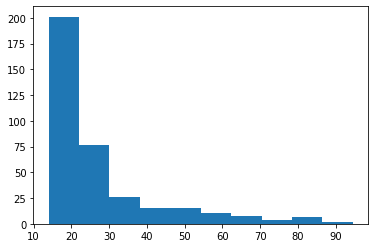

In [ ]:
plt.hist(num_panels)
plt.show()

In [ ]:
pd.DataFrame(num_panels).describe(percentiles = [0.9])

,0
count,364.000000
mean,27.417871
std,15.615220
min,13.979444
50%,20.924948
90%,50.519134
max,94.551430


In [ ]:
# Assuming cost of a single 310 Watt solar panel is 189.00$ and cost of normal electricity is 13.19 cents per kWh.
power_consumption_per_year = np.sum(uni_power_lawson)
sol_production_per_year = np.sum(sol_power_lawson) * 24
max_lim = 500 # np.max(num_panels)
sol_cost = 189
electricity_cost = 0.131

In [ ]:
#Calculating electricity cost 
excess_power = np.sum(uni_power_lawson) - (sol_production_per_year * max_lim)
excess_cost = excess_power * electricity_cost

#Calculating solar production cost
solar_fixed_cost = sol_cost * max_lim

#Total cost
cost_of_buying = electricity_cost * power_consumption_per_year

print(cost_of_buying)
print(excess_cost + solar_fixed_cost)

39615.357937500004
-726117.9860566406


In [ ]:
def years_till_breakeven(numps):
  for i in range(0,11):
    excess_power = (i * np.sum(uni_power_lawson)) - (sol_production_per_year * numps)
    if (excess_power < 0):
      excess_power = 0
    excess_cost = excess_power * electricity_cost
    cost_till_current_buying = i * cost_of_buying
    cost_till_current_solar = (i * excess_cost) + (numps * sol_cost) 
    if cost_till_current_buying > cost_till_current_solar:
      return i
  return -1

In [ ]:
costs = pd.DataFrame(columns=('Num Panels', 'Years Till Breakeven'))
for i in range(0,2269):
  j = years_till_breakeven(i)
  costs.loc[i] = [i, j]
costs.head()

,Num Panels,Years Till Breakeven
0,0,-1
1,1,1
2,2,1
3,3,1
4,4,1


[]

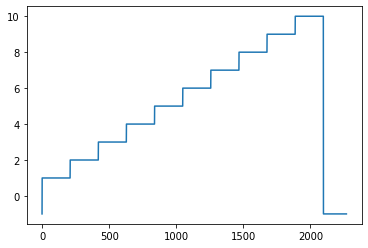

In [ ]:
plt.plot(costs['Num Panels'], costs['Years Till Breakeven'])
plt.plot()

In [ ]:
excess_power = uni_power_lawson - (sol_power_lawson * 24 * 500)
excess_power[excess_power < 0] = 0
excess_power

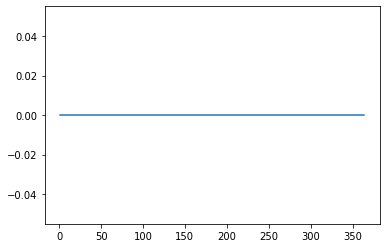

In [ ]:
plt.plot(range(1,365), excess_power)